In [25]:
%run SPDEs.ipynb
%run Rule.ipynb
%run Model.ipynb
%run Noise.ipynb
%run full_visualization.ipynb
%run Algorithm_2.ipynb
%run Burgers_PDE_FIND.ipynb

In [26]:
# Uploading the data of the same solutions. Alternatively create data as in Burgers_Numerics1.ipynb

Burgers_true = pd.read_csv("Burgers_fourier", index_col=0, header = [0,1])
Burgers_true = [Burgers_true["S"+str(i)] for i in range(1, Burgers_true.columns.levshape[0]+1)]

num_samples = len(Burgers_true)

test = np.random.choice(np.arange(num_samples), int(num_samples/6), replace = False)

T, X = Burgers_true[0].index.values, Burgers_true[0].columns.values.astype('float64')

In [27]:
noise = 0.01

Burgers_noise = np.array([B+np.random.normal(scale = noise*np.abs(B).mean().mean(), size = (len(T),len(X))) for B in Burgers_true])
for i in range(num_samples):
    Burgers_noise[i, :, -1] = Burgers_noise[i, :, 0]
    
Burgers_noise_df = [pd.DataFrame(B, index = T, columns = X) for B in Burgers_noise]

In [17]:
# Double check that approximatelly 1% error is added

show = summary(test)

er_ = show.errors(Burgers_true,[Burgers_noise_df[i] for i in test])
print('')
av_er_ = show.errors(Burgers_true,[Burgers_noise_df[i] for i in test], full = False, maxi = True)

Total relative error for all test cases: 0.009592136540225862

Average error over all test cases: 0.00923762398322718

Maximum relative error among test cases: 0.009994271854965353


In [30]:
# Algorithm 2 on the noisy data

R = Rule(kernel_deg = 2, noise_deg = -1.5, free_num = 2)

experiment_noise = IML(Burgers_noise, Rule = R, eps = 0.1, height = 3, deg = 2.5, T = T, X = X) # initialize experiment for algorithm 2
experiment_noise.set_train_test(test = test) # initialize test set

experiment_noise.set_trees() # extract trees

experiment_noise.initialize_Predictions()

experiment_noise.training_models() # Create models for Step 2 of Algorithm 2

100%|██████████| 1/1 [00:00<00:00, 328.66it/s]


Creating Model


100%|██████████| 20000/20000 [10:33<00:00, 31.56it/s]


In [31]:
experiment_noise.fit_training_model() # Linear fit for Step 2 of Algorithm 2
experiment_noise.learn_with_fitted() # Recurcive steps 3 & 4 of Algorithm 2

100%|██████████| 20/20 [00:00<00:00, 31.52it/s]


100%|██████████| 20/20 [00:01<00:00, 18.70it/s]


In [55]:
# Predicted values on tne noisy data

Prediction_noise = experiment_noise.to_df_list()

show_prediction = summary(experiment_noise.test)

er_noise = show_prediction.errors(Burgers_true, Prediction_noise)
print('')
av_er_noise = show_prediction.errors(Burgers_true, Prediction_noise, full = False, maxi = True)

Total relative error for all test cases: 0.3579307189651307

Average error over all test cases: 0.17515562567444237

Maximum relative error among test cases: 1.8608172311432842


In [19]:
# PDE-FIND with polynomial interpolation on the noisy data

# Number of equations used for the PDE-FIND algorithm
learning_samples = num_samples-len(test) 
learning_samples = 1

u = np.array([Burgers_noise[i] for i in range(len(Burgers_noise)) if i not in test])

dt, dx = T[1]-T[0], X[1]-X[0]
# get viscosity and non linear coeficient of the Burgers equation
# Use polynomial interpolation to differentiate the noisy data
eps, lambd = PDE_FIND_Burgers(u[:learning_samples], dt, dx, diff='poly', offset_x = 10, offset_t = 10, deg_x = 5, deg_t = 5)

print("Coefficients of equation obtained from PDE-FIND regression:")
print("Viscocity coef: {}, Non-lin coef: {}.".format(eps, lambd))

100%|██████████| 1/1 [00:48<00:00, 48.49s/it]

Coefficients of equation obtained from PDE-FIND regression:
Viscocity coef: 0.0457440994050389, Non-lin coef: -0.9138089971325392.


In [20]:
time_scale = 10 # increase the time interval for finer Euler scheme

T_ = np.linspace(T[0] , T[-1], time_scale*(len(T)-1)+1)

IC_ = np.array([B[0] for B in Burgers_noise])

W_ = np.zeros((num_samples, len(T_), len(X)))

Burgers_noise_FIND = SPDE(BC = 'P', IC = IC_, eps = eps).Burgers(W_, lambd = lambd, T = T_, X = X)

Burgers_noise_FIND = [pd.DataFrame(Burgers_noise_FIND[i, ::time_scale, :], index = T, columns = X) for i in test]

  6%|▌         | 119/2000 [00:00<00:03, 581.91it/s]<ipython-input-16-e020bc4ef242>:225: RuntimeWarning: overflow encountered in multiply
  current = Solution[:,i-1,:] - lambd*Solution[:,i-1,:]*self.discrete_diff(Solution[:,i-1,:], len(X), flatten = False, higher = False)*dt/dx + self.sigma_(Solution[:,i-1,:]) * dW[:,i,:]
100%|██████████| 2000/2000 [00:03<00:00, 586.10it/s]


In [21]:
test_without_nan = [test[i] for i in range(len(test)) if not Burgers_noise_FIND[i].isnull().values.any()]
Burgers_noise_FIND_ = [B for B in Burgers_noise_FIND if not B.isnull().values.any()]

print('Numerical Scheme failed for {} equation with the above coeficients.'.format(len(test)-len(test_without_nan)))

Numerical Scheme failed for 1 equation with the above coeficients.


In [22]:
show_FIND = summary(test_without_nan)

er_noise = show_FIND.errors(Burgers_true, Burgers_noise_FIND_)
print('')
av_er_noise = show_FIND.errors(Burgers_true, Burgers_noise_FIND_, full = False, maxi = True)

Total relative error for all test cases: 0.32781779532761607

Average error over all test cases: 0.4295767375290598

Maximum relative error among test cases: 0.9216140020912656


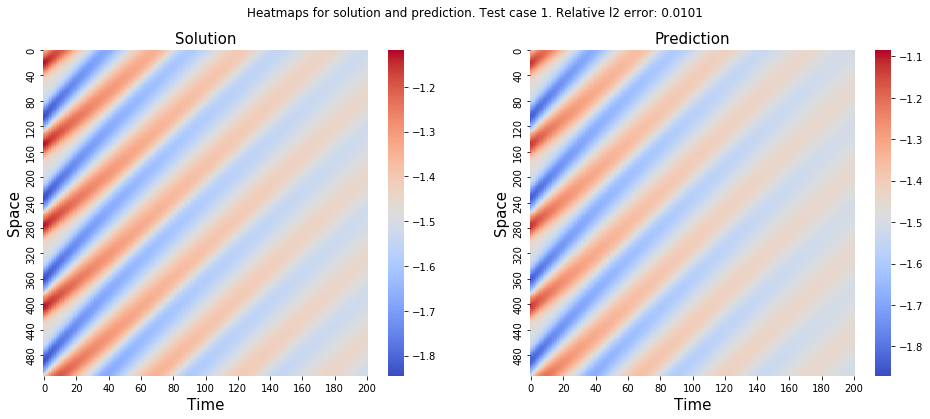

In [58]:
show_prediction.full_comparison(0, Burgers_true, Prediction_noise)

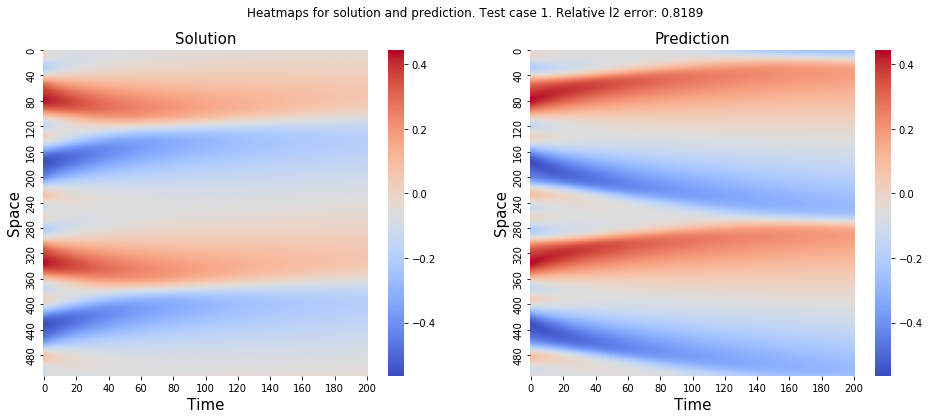

In [24]:
show_FIND.full_comparison(0, Burgers_noise_df, Burgers_noise_FIND_)